In [172]:
#Importing
#!conda install geopandas --y

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import seaborn as sns
import tensorflow as tf
import geopandas as gpd

from shapely.geometry import Point

from statsmodels.tsa.stattools import adfuller

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import KFold, cross_val_score, train_test_split, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (classification_report, accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, 
mean_absolute_error, mean_squared_error)
from sklearn.feature_selection import RFECV, mutual_info_classif
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

from scikeras.wrappers import KerasClassifier

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Embedding, Input, Flatten
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.utils import to_categorical
from keras.callbacks import EarlyStopping

In [3]:
#Importing Data
data = pd.read_csv("data/ACLED2021-2024.csv")

location_data = data.copy()

data.drop(columns=['time_precision', 'assoc_actor_1', 'assoc_actor_2', 'iso', 'region', 'admin3', 'location', 
                  'latitude', 'longitude', 'geo_precision', 'source_scale', 'timestamp', 'tags', 'population_best', 'event_id_cnty'], 
          inplace=True)

print(data.shape)


data['event_date'] = pd.to_datetime(data['event_date'], errors = 'coerce') #changing to datetime

#data.set_index('event_date', inplace=True)
#data.index = pd.to_datetime(data.index)
data.sort_index(inplace=True)

print(data.shape)
#data = data.dropna(subset=['event_date'])

(38130, 17)
(38130, 17)


In [4]:
# Dropping Dupes
initial_row_count = data.shape[0]
data = data.drop_duplicates()
final_row_count = data.shape[0]
print(f"Removed {initial_row_count - final_row_count} duplicates")
print(data.shape)

Removed 40 duplicates
(38090, 17)


In [5]:
#Reformatting / Cleaning

#Addressing NA values - Categorical, NUmerical and date
categorical_columns = ['disorder_type', 'event_type', 'sub_event_type', 'actor1', 'actor2', 'civilian_targeting', 
                       'country', 'admin1', 'admin2', 'source', 'notes']
categorical_columns = data[categorical_columns]


for column in categorical_columns:
    data[column] = data[column].fillna('Not specified')

numerical_columns = ['fatalities', 'inter1', 'inter2', 'interaction']

for column in numerical_columns:
    data[column] = data[column].fillna(data[column].median()) #using median to fill
    
#print(data.isna().sum())
print(data.shape)
#data.loc[:, 'actor2'] = data['actor2'].fillna('Not specified')
#data.loc[:, 'civilian_targeting'] = data['civilian_targeting'].fillna('Not specified')

(38090, 17)


In [6]:
#Grouping Together Actor1 and 2
def consolidate_names(name):
    if 'Military Forces of Israel' in name:
        return 'Military Forces of Israel'
    elif 'Police Forces of Israel' in name:
        return 'Police Forces of Israel'
    elif 'Hamas Movement' in name:
        return 'Hamas Movement'
    elif 'Police Forces of Israel' in name or 'Government of Israel' in name:
        return 'Government and Police Forces of Israel'
    elif 'Police Forces of Palestine' in name or 'Government of Palestine' in name:
        return 'Government and Police Forces of Palestine'
    elif 'PIJ:' in name or 'Islamic Jihad' in name:
        return 'Palestinian Islamic Jihad'
    elif 'Hezbollah' in name:
        return 'Hezbollah'
    elif 'Al Aqsa' in name:
        return 'Al Aqsa Martyrs Brigade'
    elif 'Katibat' in name:
        return 'Katibat Groups (Palestine)'
    elif 'PFLP:' in name:
        return 'Popular Front for the Liberation of Palestine'
    elif 'DFLP:' in name:
        return 'Democratic Front for the Liberation of Palestine'
    elif 'Military Forces of Iran' in name:
        return 'Iranian Revolutionary Guard Corps'
    elif 'Islamic State' in name:
        return 'Islamic State'
#civilians
    elif 'Civilians' in name:
        if 'Israel' in name or 'Palestine' in name:
            return name  #Keeping isr and pal civilians
        else:
            return 'Civilians (International)'  # grouping others as int.
#armed groups
    elif 'Unidentified Armed Group' in name:
        if 'Israel' in name or 'Palestine' in name:
            return name  
        else:
            return 'Unidentified Armed Group (International)'
#military forces
    elif 'Military Forces of' in name:
        if 'Israel' in name or 'Palestine' in name:
            return name  
        else:
            return 'Military Forces of International Forces'
    elif 'Settlers' in name:
        return 'Settlers (Israel)'
    elif 'Protesters' in name or 'Rioters' in name:
        return name  # Retains specific categories due to their distinct contexts
    else:
        return name #'Other Groups' 

# Apply the consolidation function to both actor1 and actor2
data['actor1_grouped'] = data['actor1'].apply(consolidate_names)
data['actor2_grouped'] = data['actor2'].apply(consolidate_names)

In [7]:
#Grouping smaller entities
actor1_counts = data['actor1_grouped'].value_counts()
actor2_counts = data['actor2_grouped'].value_counts()

def consolidate_small_groups(name, counts): #Check if Isr or Pal if not 'name'
    if counts[name] < 10:
        if 'Israel' in name:
            return 'Other (Israel)'
        elif 'Palestine' in name:
            return 'Other (Palestine)'
        else:
            return'Other Group'
    else:
        # Return the name if the count is 10 or more
        return name

# Apply the consolidation function to both actor1_grouped and actor2_grouped
data['actor1_grouped'] = data['actor1_grouped'].apply(lambda x: consolidate_small_groups(x, actor1_counts))
data['actor2_grouped'] = data['actor2_grouped'].apply(lambda x: consolidate_small_groups(x, actor2_counts))


# Print the new value counts to confirm re-categorization
#print(data['actor1_grouped'].value_counts())
#print(data['actor2_grouped'].value_counts())

data['actor1'] = data['actor1_grouped']
data['actor2'] = data['actor2_grouped']

data.drop(['actor1_grouped', 'actor2_grouped'], axis=1, inplace=True)
print(data.isna().sum())
# calculate the percentage of zero values per column
zero_counts = (data == 0).astype(int).sum(axis=0)
zero_percentage = 100 * zero_counts / len(data)

# display the columns with high percentages of zeros
print("Percentage of zeros in each column:")
print(zero_percentage[zero_percentage > 0])  # Adjust the threshold as necessary


event_date            0
year                  0
disorder_type         0
event_type            0
sub_event_type        0
actor1                0
inter1                0
actor2                0
inter2                0
interaction           0
civilian_targeting    0
country               0
admin1                0
admin2                0
source                0
notes                 0
fatalities            0
dtype: int64
Percentage of zeros in each column:
inter2        27.274875
fatalities    91.047519
dtype: float64


In [8]:
#Creating Temporal Features for T-S

#Date related
data['year'] = data['event_date'].dt.year
data['month'] = data['event_date'].dt.month
data['day'] = data['event_date'].dt.day
data['day_of_week'] = data['event_date'].dt.day_name()
data['days_since_start'] = (data['event_date'] - data['event_date'].min()).dt.days

# time since last event of the same type
data['time_since_last_event'] = data.groupby('event_type')['event_date'].diff().dt.days
#data['time_since_last_event'] = data.groupby('event_type').apply(lambda x: x.index.to_series().diff().dt.days).reset_index(level=0, drop=True)


# time since last disorder of the same type
data['time_since_last_disorder'] = data.groupby('disorder_type')['event_date'].diff().dt.days
#data['time_since_last_disorder'] = data.groupby('disorder_type').apply(lambda x: x.index.to_series().diff().dt.days).reset_index(level=0, drop=True)
#print(data[['time_since_last_event', 'time_since_last_disorder']].head())


# rolling avg for fatalities
data['rolling_avg_fatalities_7d'] = data.groupby(
    'event_type')['fatalities'].transform(lambda x: x.rolling(window=7, min_periods=1).mean())


# cumulative counts of events and fatalities by specific features
data['cumulative_events'] = data.groupby(['event_type']).cumcount() + 1
data['cumulative_fatalities'] = data.groupby(['event_type'])['fatalities'].cumsum()

log_data = data.copy()


In [9]:
#All data cleaning steps on LOCATION DATA
location_data['event_date'] = pd.to_datetime(location_data['event_date'], errors='coerce')  # Convert to datetime

location_data.sort_index(inplace=True)

# Drop duplicates and record the count before and after
initial_row_count = location_data.shape[0]
location_data.drop_duplicates(inplace=True)
final_row_count = location_data.shape[0]

# Fill missing categorical data
categorical_columns = ['disorder_type', 'event_type', 'sub_event_type', 'actor1', 'actor2', 'civilian_targeting', 
                       'country', 'admin1', 'admin2', 'source', 'notes']
for column in categorical_columns:
    location_data[column] = location_data[column].fillna('Not specified')
    
# Fill missing numerical data
numerical_columns = ['fatalities', 'inter1', 'inter2', 'interaction', 'longitude', 'latitude']
for column in numerical_columns:
    location_data[column] = location_data[column].fillna(location_data[column].median())

# Assume consolidate_names is a function that's already defined
location_data['actor1_grouped'] = location_data['actor1'].apply(consolidate_names)
location_data['actor2_grouped'] = location_data['actor2'].apply(consolidate_names)

# Calculate value counts for grouped actors
actor1_counts = location_data['actor1_grouped'].value_counts()
actor2_counts = location_data['actor2_grouped'].value_counts()

# Assume consolidate_small_groups is a function that's already defined
# Apply consolidation function based on counts
location_data['actor1_grouped'] = location_data['actor1_grouped'].apply(lambda x: consolidate_small_groups(x, actor1_counts))
location_data['actor2_grouped'] = location_data['actor2_grouped'].apply(lambda x: consolidate_small_groups(x, actor2_counts))

# Update the 'actor1' and 'actor2' columns
location_data['actor1'] = location_data['actor1_grouped']
location_data['actor2'] = location_data['actor2_grouped']

# Drop the temporary grouped columns
location_data.drop(['actor1_grouped', 'actor2_grouped'], axis=1, inplace=True)

<Figure size 1500x800 with 0 Axes>

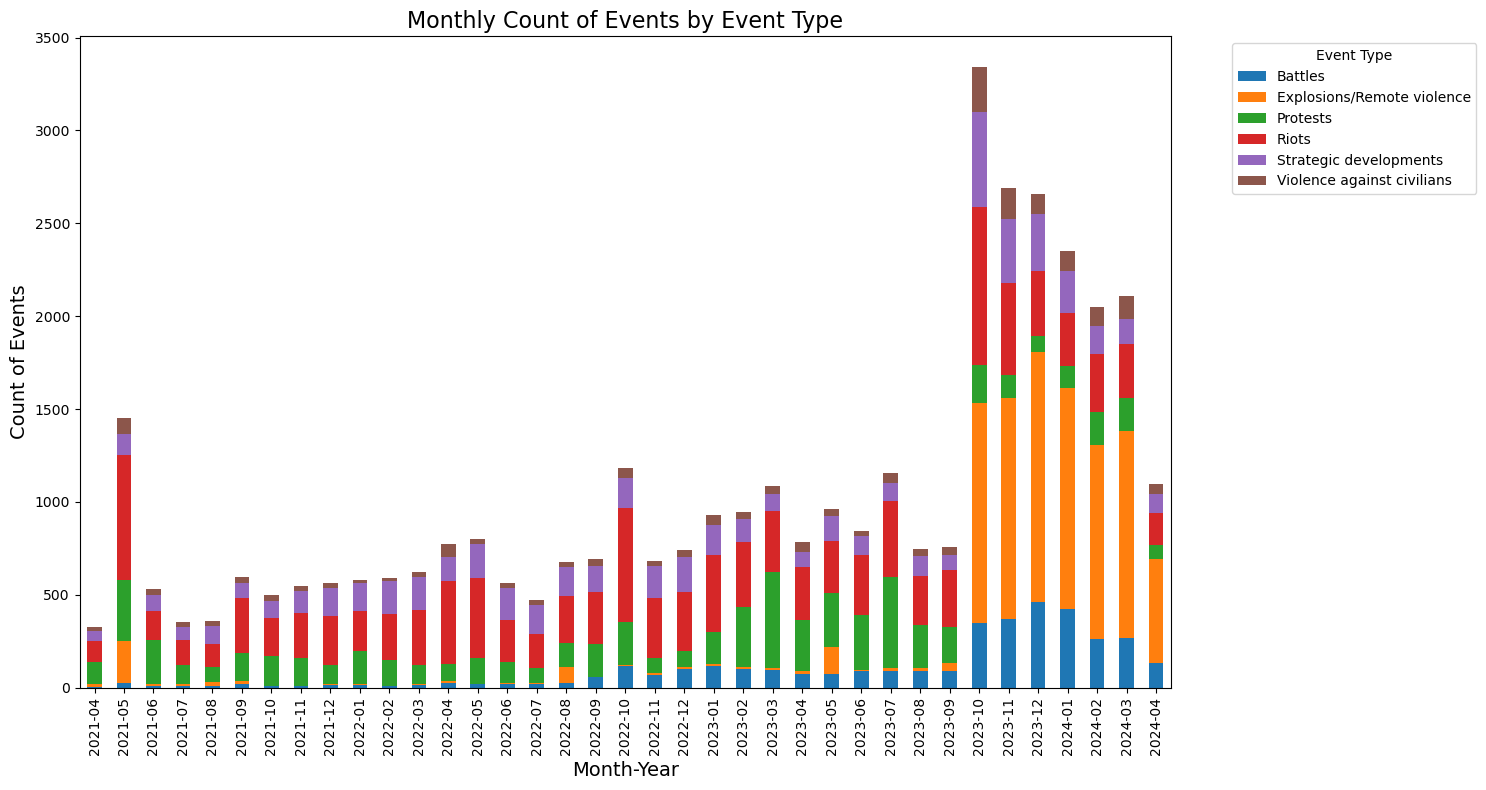

In [10]:
# Plotting the count of events over time by event_type
data['month_year'] = data['event_date'].dt.to_period('M') #group data into month

# countplot with monthly data
plt.figure(figsize=(15, 8))
monthly_data = data.groupby(['month_year', 'event_type']).size().reset_index(name='counts')

#creating'event_type' columns
monthly_pivot = monthly_data.pivot(index='month_year', columns='event_type', values='counts').fillna(0)

monthly_pivot.plot(kind='bar', stacked=True, figsize=(15, 8))
plt.title('Monthly Count of Events by Event Type', fontsize=16)
plt.xlabel('Month-Year', fontsize=14)
plt.ylabel('Count of Events', fontsize=14)
plt.xticks(rotation=90)
plt.legend(title='Event Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

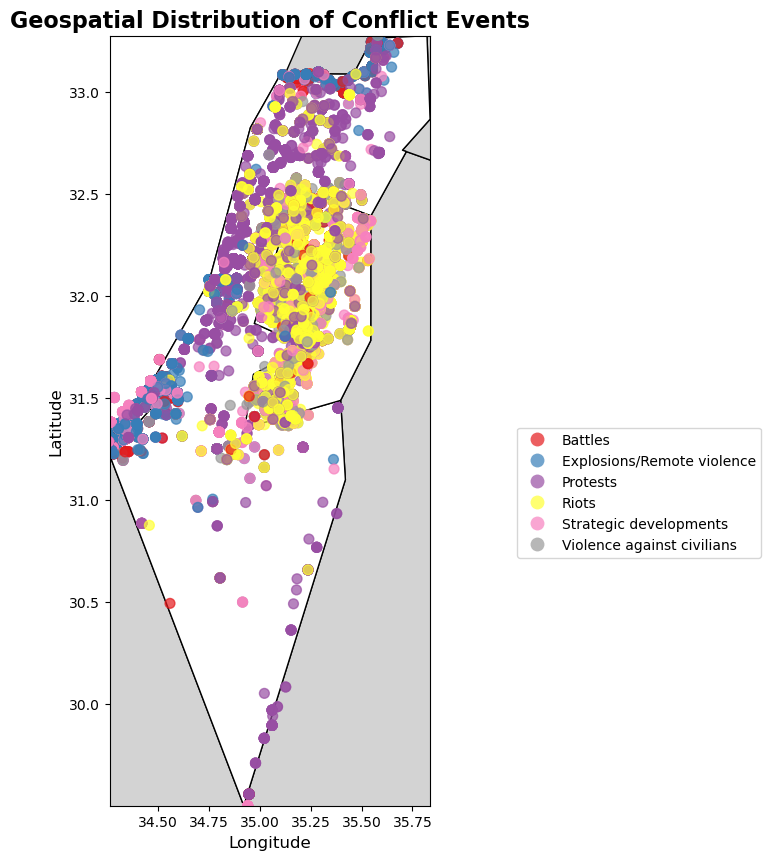

In [11]:
geometry = [Point(xy) for xy in zip(location_data.longitude, location_data.latitude)]
geo_df = gpd.GeoDataFrame(location_data, geometry=geometry)

fig, ax = plt.subplots(1, 1, figsize=(5, 10))

# Load a world map shapefile and plot the world in a light grey
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world.plot(ax=ax, color='lightgrey', edgecolor='black')

# Plot Israel and Palestine with a clear edge
isr_pal = world[(world.name == "Israel") | (world.name == "Palestine")]
isr_pal.plot(ax=ax, color='white', edgecolor='black')

geo_df.plot(ax=ax, column='event_type', legend=True, markersize=50, cmap='Set1', alpha=0.7)

leg = ax.get_legend()
if leg:  
    leg.set_bbox_to_anchor((1.25, 0.5))

# Set the limits to frame the region of interest
plt.xlim(isr_pal.bounds.minx.min(), isr_pal.bounds.maxx.max())
plt.ylim(isr_pal.bounds.miny.min(), isr_pal.bounds.maxy.max())

# Set title and axis labels
plt.title('Geospatial Distribution of Conflict Events', fontsize=16, weight='bold')
plt.xlabel('Longitude', fontsize=12)
plt.ylabel('Latitude', fontsize=12)

# Remove axis for a cleaner look
plt.axis('on')

# Show the plot
plt.show()

In [12]:
#log transformations
log_columns = ['fatalities', 'cumulative_events', 'cumulative_fatalities', 'rolling_avg_fatalities_7d', 
               'time_since_last_event', 'time_since_last_disorder', 'days_since_start']
for col in log_columns:
    log_data['log_' + col] = np.log1p(log_data[col])

# creating lagged features
for col in log_columns:
    log_col = 'log_' + col
    for lag in [1, 2, 3]:
        log_data[f'{log_col}_lag{lag}'] = log_data[log_col].shift(lag)

/Users/Arya/miniforge3/envs/venv-metal/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/Arya/miniforge3/envs/venv-metal/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/Arya/miniforge3/envs/venv-metal/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/Arya/miniforge3/envs/venv-metal/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [13]:
log_data

,event_date,year,disorder_type,event_type,sub_event_type,actor1,inter1,actor2,inter2,interaction,...,log_rolling_avg_fatalities_7d_lag3,log_time_since_last_event_lag1,log_time_since_last_event_lag2,log_time_since_last_event_lag3,log_time_since_last_disorder_lag1,log_time_since_last_disorder_lag2,log_time_since_last_disorder_lag3,log_days_since_start_lag1,log_days_since_start_lag2,log_days_since_start_lag3
0,2024-04-19,2024,Political violence,Explosions/Remote violence,Shelling/artillery/missile attack,Hamas Movement,3,Not specified,0,30,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2024-04-19,2024,Demonstrations,Protests,Peaceful protest,Protesters (Israel),6,Not specified,0,60,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.999422,NaN,NaN
2,2024-04-19,2024,Demonstrations,Riots,Violent demonstration,Rioters (Israel),5,Rioters (Israel),5,55,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.999422,6.999422,NaN
3,2024-04-19,2024,Demonstrations,Protests,Peaceful protest,Protesters (Israel),6,Not specified,0,60,...,0.0,NaN,NaN,NaN,0.0,NaN,NaN,6.999422,6.999422,6.999422
4,2024-04-19,2024,Political violence,Battles,Armed clash,Hezbollah,3,Military Forces of Israel,1,13,...,0.0,0.0,NaN,NaN,0.0,0.0,NaN,6.999422,6.999422,6.999422
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38125,2021-04-20,2021,Strategic developments,Strategic developments,Other,Military Forces of Israel,8,Civilians (Palestine),7,78,...,0.0,0.0,-inf,0.0,0.0,-inf,0.0,0.000000,0.000000,0.000000
38126,2021-04-20,2021,Political violence,Riots,Mob violence,Rioters (Israel),5,Not specified,0,50,...,0.0,0.0,0.0,-inf,0.0,0.0,-inf,0.000000,0.000000,0.000000
38127,2021-04-20,2021,Demonstrations,Protests,Peaceful protest,Protesters (Palestine),6,Not specified,0,60,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
38128,2021-04-20,2021,Political violence,Riots,Mob violence,Rioters (Israel),5,Civilians (Palestine),7,57,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000


In [14]:
print(log_data.isna().sum())

# percentage of zero values
zero_counts = (log_data == 0).astype(int).sum(axis=0)
zero_percentage = 100 * zero_counts / len(log_data)
print(zero_percentage[zero_percentage > 0])


event_date                              0
year                                    0
disorder_type                           0
event_type                              0
sub_event_type                          0
actor1                                  0
inter1                                  0
actor2                                  0
inter2                                  0
interaction                             0
civilian_targeting                      0
country                                 0
admin1                                  0
admin2                                  0
source                                  0
notes                                   0
fatalities                              0
month                                   0
day                                     0
day_of_week                             0
days_since_start                        0
time_since_last_event                   6
time_since_last_disorder                4
rolling_avg_fatalities_7d         

In [15]:
#replacing infinities w NaN
log_data.replace([np.inf, -np.inf], np.nan, inplace=True)
#log_data.fillna(log_data.median(), inplace=True)

#median for numeric columns
numeric_medians = log_data.select_dtypes(include=[np.number]).median()
log_data.fillna(numeric_medians, inplace=True)


log_data['time_since_last_event'].fillna(method='ffill', inplace=True)
log_data['time_since_last_event'].fillna(method='bfill', inplace=True)

lag_cols = [col for col in log_data.columns if ('log_time_since_last_event' in col or 'lag' in col) and 
            np.issubdtype(log_data[col].dtype, np.number)]

In [16]:
print(log_data.shape)
print(log_data.isna().sum())

# percentage of zero values
zero_counts = (log_data == 0).astype(int).sum(axis=0)
zero_percentage = 100 * zero_counts / len(log_data)
print(zero_percentage[zero_percentage > 0])

(38090, 54)
event_date                            0
year                                  0
disorder_type                         0
event_type                            0
sub_event_type                        0
actor1                                0
inter1                                0
actor2                                0
inter2                                0
interaction                           0
civilian_targeting                    0
country                               0
admin1                                0
admin2                                0
source                                0
notes                                 0
fatalities                            0
month                                 0
day                                   0
day_of_week                           0
days_since_start                      0
time_since_last_event                 0
time_since_last_disorder              0
rolling_avg_fatalities_7d             0
cumulative_events           

In [17]:
print(log_data.dtypes)
unique_counts = log_data.nunique()
print(unique_counts)

event_date                            datetime64[ns]
year                                           int32
disorder_type                                 object
event_type                                    object
sub_event_type                                object
actor1                                        object
inter1                                         int64
actor2                                        object
inter2                                         int64
interaction                                    int64
civilian_targeting                            object
country                                       object
admin1                                        object
admin2                                        object
source                                        object
notes                                         object
fatalities                                     int64
month                                          int32
day                                           

In [18]:
#Encoding

#One-Hot for Categoricals
categorical_cols = ['disorder_type', 'sub_event_type' ,'event_type','civilian_targeting',
                    'country', 'admin1', 'admin2', 'day_of_week', 'inter1', 'inter2', 'interaction']
log_data_encoded = pd.get_dummies(log_data, columns=categorical_cols)
log_data_encoded

#Label Encoder
label_encoders = {}

for col in ['actor1', 'actor2']:
    le = LabelEncoder()
    log_data_encoded[col] = le.fit_transform(log_data_encoded[col])
    label_encoders[col] = le  # storing the encoder
log_data_encoded.to_csv('data/log_data_encoded.csv', index=False)
#print(log_data_encoded.isna().sum())

log_data_encoded = log_data_encoded.apply(lambda col: col.astype(int) if pd.api.types.is_bool_dtype(col) else col) 
#SO IMPORTANT! changes values of bool to int

In [19]:
log_data_encoded

,event_date,year,actor1,actor2,source,notes,fatalities,month,day,days_since_start,...,interaction_57,interaction_58,interaction_60,interaction_66,interaction_68,interaction_70,interaction_77,interaction_78,interaction_80,interaction_88
0,2024-04-19,2024,3,10,N12; Times of Israel,"Interception: On 19 April 2024, Hamas militant...",0,4,19,1095,...,0,0,0,0,0,0,0,0,0,0
1,2024-04-19,2024,17,10,Ynet,"On 19 April 2024, thousands formed a human cha...",0,4,19,1095,...,0,0,1,0,0,0,0,0,0,0
2,2024-04-19,2024,19,18,Haaretz; Jerusalem Post; N12; Times of Israel;...,"On 19 April 2024, dozens of relatives of hosta...",0,4,19,1095,...,0,0,0,0,0,0,0,0,0,0
3,2024-04-19,2024,17,10,Ynet,"On 19 April 2024, thousands formed a human cha...",0,4,19,1095,...,0,0,1,0,0,0,0,0,0,0
4,2024-04-19,2024,4,8,Jerusalem Post; Ma'ariv; Times of Israel,"On 19 April 2024, Hezbollah forces in Lebanon ...",0,4,19,1095,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38125,2021-04-20,2021,8,2,PLO Negotiations Affairs Department,"Other: On 20 April 2021, Israeli military forc...",0,4,20,0,...,0,0,0,0,0,0,0,1,0,0
38126,2021-04-20,2021,19,10,PLO Negotiations Affairs Department,"On 20 April 2021, Israeli settlers uprooted 20...",0,4,20,0,...,0,0,0,0,0,0,0,0,0,0
38127,2021-04-20,2021,18,10,Ma'an News Agency,"On 20 April 2021, a large protest organized by...",0,4,20,0,...,0,0,1,0,0,0,0,0,0,0
38128,2021-04-20,2021,19,2,PLO Negotiations Affairs Department,"On 20 April 2021, Israeli settlers from the Ba...",0,4,20,0,...,1,0,0,0,0,0,0,0,0,0


In [20]:
print(log_data_encoded.dtypes)
unique_counts = log_data_encoded.nunique()
#print(unique_counts)

event_date        datetime64[ns]
year                       int32
actor1                     int64
actor2                     int64
source                    object
                       ...      
interaction_70             int64
interaction_77             int64
interaction_78             int64
interaction_80             int64
interaction_88             int64
Length: 169, dtype: object


In [21]:
# Correlation Analysis for numerical cols
numerical_cols = log_data_encoded.select_dtypes(include=['int64', 'float64']).columns
numerical_data = log_data_encoded[numerical_cols]
correlation_matrix = numerical_data.corr()
correlation_matrix

threshold = 0.85
upper = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(np.bool_))
to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
print(to_drop)
print(log_data_encoded.shape)
#dropping
log_data_encoded_dropped = log_data_encoded.drop(columns=to_drop)
print(f"Data shape after dropping highly correlated features: {log_data_encoded_dropped.shape}")

['log_rolling_avg_fatalities_7d', 'log_days_since_start', 'log_days_since_start_lag1', 'log_days_since_start_lag2', 'log_days_since_start_lag3', 'sub_event_type_Excessive force against protesters', 'event_type_Battles', 'event_type_Protests', 'event_type_Riots', 'event_type_Strategic developments', 'event_type_Violence against civilians', 'admin2_Jerusalem', 'admin2_Tel Aviv', 'inter1_5', 'inter1_6', 'interaction_27', 'interaction_47', 'interaction_55', 'interaction_60', 'interaction_66']
(38090, 169)
Data shape after dropping highly correlated features: (38090, 149)


In [22]:
# target columns
sub_event_type_columns = [col for col in log_data_encoded.columns if col.startswith('sub_event_type_')]

# taking out the features, text, datetime
features = log_data_encoded.drop(columns=['event_date', 'source', 'notes'] + sub_event_type_columns)

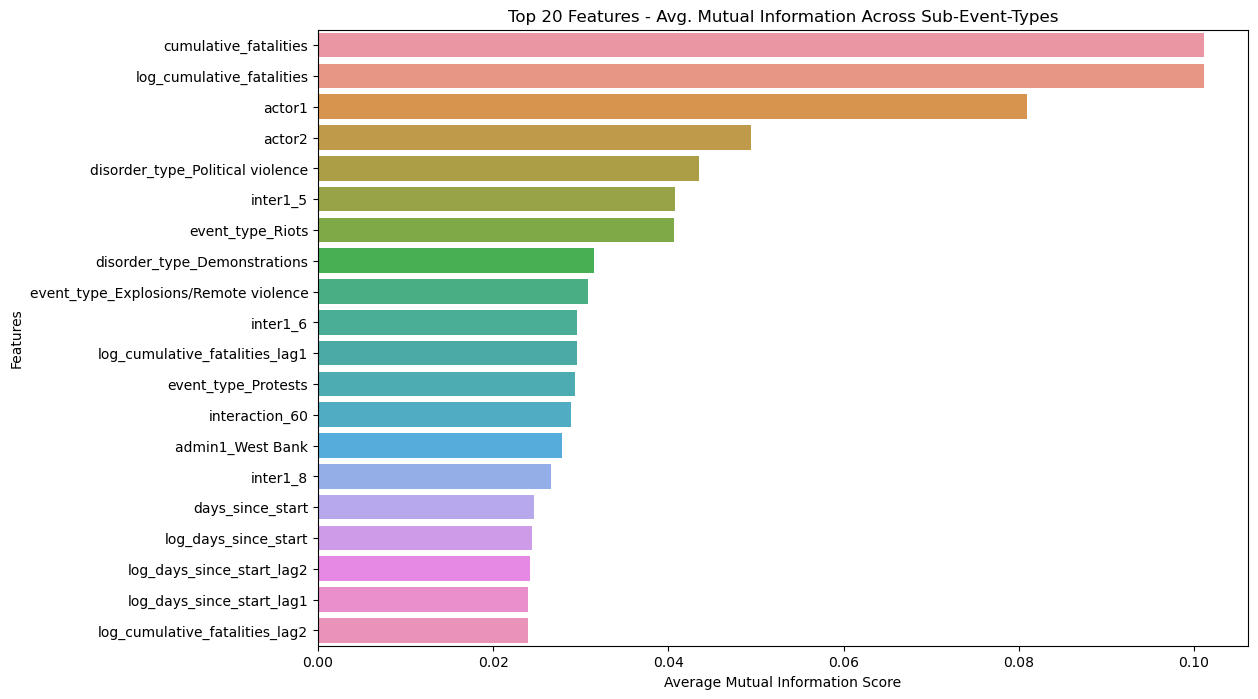

In [23]:
#Mututal Information features

# actual mi score calculation
mi_scores_df = pd.DataFrame()

for target in sub_event_type_columns:
    mi_scores = mutual_info_classif(features, log_data_encoded[target], discrete_features='auto')
    mi_scores_df[target] = mi_scores

#creating mi_scores + top 20 features shown below
mi_scores_df['average_mi_score'] = mi_scores_df.mean(axis=1)
mi_scores_df['feature'] = features.columns

if 'feature' in mi_scores_df.columns:
    top_features_mi = mi_scores_df.sort_values('average_mi_score', ascending=False).head(20)['feature'].tolist()
else:
    top_features_mi = mi_scores_df.sort_values('average_mi_score', ascending=False).head(20).index.tolist()

plt.figure(figsize=(12, 8))
sns.barplot(x='average_mi_score', y='feature', data=mi_scores_df.sort_values('average_mi_score', ascending=False).head(20))
plt.title('Top 20 Features - Avg. Mutual Information Across Sub-Event-Types')
plt.xlabel('Average Mutual Information Score')
plt.ylabel('Features')
plt.show()

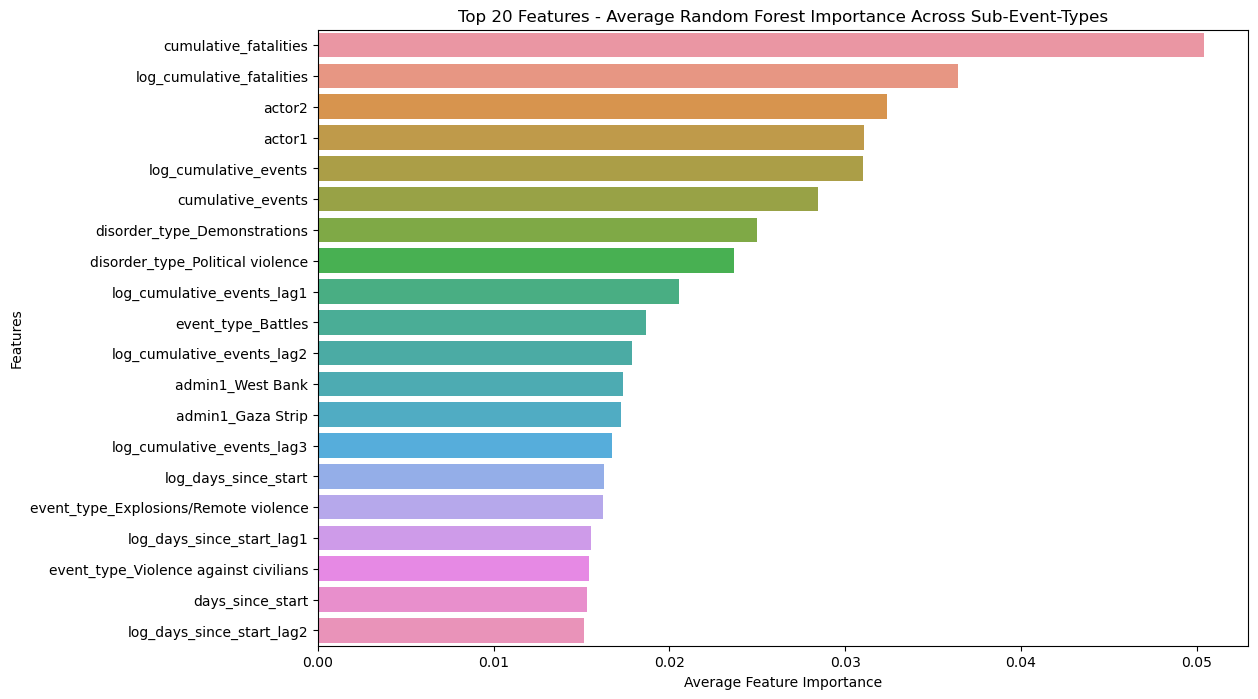

In [24]:
#Random Forest Importance
#numeric_encoded_log_data
#Dropping numeric + T/T Splitting

#feature importances
importances_df = pd.DataFrame(index=features.columns)

for target in sub_event_type_columns:
    X_train, X_test, y_train, y_test = train_test_split(features, log_data_encoded[target], test_size=0.2, random_state=42, shuffle=False)
    forest = RandomForestClassifier(random_state=42)
    forest.fit(X_train, y_train)
    importances_df[target] = forest.feature_importances_

# Calculate the average feature importance across all sub_event_type targets
importances_df['average_importance'] = importances_df.mean(axis=1)

if 'feature' in importances_df.columns:
    top_features_rf = importances_df.sort_values('average_importance', ascending=False).head(20)['feature'].tolist()
else:
    top_features_rf = importances_df.sort_values('average_importance', ascending=False).head(20).index.tolist()


# Plotting the average feature importances
plt.figure(figsize=(12, 8))
sorted_importances = importances_df['average_importance'].sort_values(ascending=False).head(20)
sns.barplot(x=sorted_importances.values, y=sorted_importances.index)
plt.title('Top 20 Features - Average Random Forest Importance Across Sub-Event-Types')
plt.xlabel('Average Feature Importance')
plt.ylabel('Features')
plt.show()

In [25]:
print(mi_scores_df.shape)
print(importances_df.shape)

(146, 22)
(146, 21)


In [26]:
combined_features = list(set(top_features_mi + top_features_rf))

# Before filtering, let's confirm that all these feature names are valid
invalid_features = [feature for feature in combined_features if feature not in log_data_encoded.columns]
if invalid_features:
    print("Invalid feature names:", invalid_features)
else:
    # Filter the original dataset to only include the combined top features
    filtered_dataset = log_data_encoded[combined_features + ['event_date', 'source', 'notes']] 

    print("Filtered Dataset Shape:", filtered_dataset.shape)

Filtered Dataset Shape: (38090, 31)


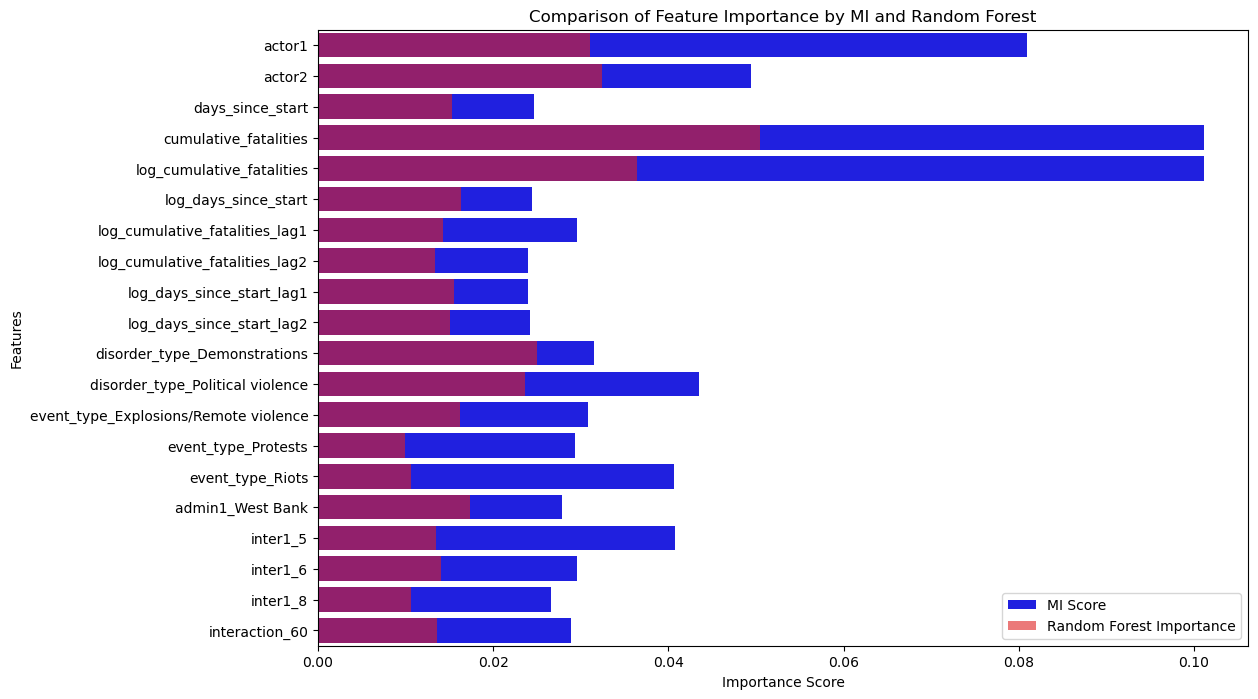

In [27]:
rf_df = pd.DataFrame({'feature': X_train.columns,
                                    'RF_Importance': importances_df['average_importance']})

#merging datasets
combined_importances = pd.merge(mi_scores_df, rf_df, on='feature', how='outer')

combined_importances.sort_values(by='average_mi_score', ascending=False, inplace=True)

combined_importances = pd.merge(mi_scores_df, rf_df, on='feature', how='outer')

#set the amount of feaatures
sorted_idx = combined_importances.sort_values(by='average_mi_score', ascending=False)['feature'].head(20)


plt.figure(figsize=(12, 8))
sns.barplot(x='average_mi_score', y='feature', data=combined_importances[combined_importances['feature'].isin(sorted_idx)], 
            color='blue', label='MI Score')
sns.barplot(x='RF_Importance', y='feature', data=combined_importances[combined_importances['feature'].isin(sorted_idx)], 
            color='red', alpha=0.6, label='Random Forest Importance')
plt.title('Comparison of Feature Importance by MI and Random Forest')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.legend()
plt.show()


In [28]:
# MI score
mi_percentile = 80  # aka keeping top 30%
mi_threshold = np.percentile(mi_scores_df['average_mi_score'], mi_percentile)
#top_mi_features = mi_df[mi_df['MI_Score'] >= mi_threshold]
selected_mi_features = mi_scores_df[mi_scores_df['average_mi_score'] >= mi_threshold]['feature'].tolist()
#top_mi_features.shape
#print(selected_mi_features)

# random forest importance
rf_percentile = 80  # aka keeping top 20% | top 30% is 43 features
rf_threshold = np.percentile(rf_df['RF_Importance'], rf_percentile)
#top_rf_features = rf_df[rf_df['RF_Importance'] >= rf_threshold]
selected_rf_features = rf_df[rf_df['RF_Importance'] >= 
                                      rf_threshold]['feature'].tolist()
#top_rf_features.shape
#print(selected_rf_features)

#Combining into 1
selected_features = list(set(selected_mi_features) & set(selected_rf_features))

In [29]:
selected_features

['admin1_Gaza Strip',
 'actor1',
 'cumulative_fatalities',
 'log_days_since_start_lag1',
 'log_cumulative_fatalities',
 'inter1_5',
 'log_cumulative_fatalities_lag1',
 'log_days_since_start',
 'interaction_60',
 'event_type_Explosions/Remote violence',
 'disorder_type_Strategic developments',
 'inter1_6',
 'event_type_Strategic developments',
 'civilian_targeting_Not specified',
 'log_rolling_avg_fatalities_7d',
 'disorder_type_Political violence',
 'days_since_start',
 'actor2',
 'inter2_0',
 'event_type_Battles',
 'log_days_since_start_lag3',
 'log_days_since_start_lag2',
 'admin1_West Bank',
 'disorder_type_Demonstrations']

In [30]:
print(len(selected_features))
print(len(set(selected_features))) #unique


24
24


In [119]:
#Selected Features
X_selected = log_data_encoded[selected_features].copy()
y = np.argmax(log_data_encoded[sub_event_type_columns].values, axis=1)

X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42, shuffle=False)

y_train_encoded = tf.keras.utils.to_categorical(y_train)
y_test_encoded = tf.keras.utils.to_categorical(y_test)

In [120]:
#X_train = X_train.astype({col: 'int64' for col in X_train.columns if X_train[col].dtype == 'bool'})
#X_test = X_test.astype({col: 'int64' for col in X_test.columns if X_test[col].dtype == 'bool'})
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)
print("Encoded Y")
print(y_train_encoded.shape)
print(y_test_encoded.shape)
print(y_train_encoded.dtype)
print(y_test_encoded.dtype)
#print(X_train.dtypes)

(30472, 24)
(7618, 24)
(30472,)
(7618,)
Encoded Y
(30472, 20)
(7618, 20)
float32
float32


In [69]:
#print(X_selected_train.head())
#print(y_train.head())
#print(y_train_encoded)

In [70]:
#Decision Tree Baseline

tree_classifier = DecisionTreeClassifier(random_state=42)

tree_classifier.fit(X_train_simple, y_train_encoded_simple)

tree_predictions = tree_classifier.predict(X_test_simple)

tree_accuracy = accuracy_score(y_test_encoded_simple, tree_predictions)
tree_classification_report = classification_report(y_test_encoded_simple, tree_predictions)
print(f"Accuracy of Decision Tree: {tree_accuracy:.2f}")
print(tree_classification_report)

Accuracy of Decision Tree: 0.93
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.00      0.00      0.00         1
           2       0.83      0.74      0.78       152
           3       1.00      1.00      1.00       161
           4       0.09      0.29      0.14        14
           5       1.00      1.00      1.00       440
           6       0.96      0.86      0.91        64
           7       0.67      0.98      0.80        44
           8       1.00      1.00      1.00       108
           9       0.00      0.00      0.00         0
          10       0.12      0.50      0.20         2
          11       0.95      0.26      0.41       564
          12       1.00      1.00      1.00      2720
          13       0.00      0.00      0.00         0
          14       0.66      0.98      0.79       752
          15       1.00      1.00      1.00      1519
          16       1.00      0.99      0.99      

/Users/Arya/miniforge3/envs/venv-metal/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/Arya/miniforge3/envs/venv-metal/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [73]:
# Logistic Regression
logistic_regressor = LogisticRegression(max_iter=1000, random_state=42)

logistic_regressor.fit(X_train_simple, y_train_simple)

logistic_predictions = logistic_regressor.predict(X_test_simple)

logistic_accuracy = accuracy_score(y_test_simple, logistic_predictions)
logistic_classification_report = classification_report(y_test_simple, logistic_predictions)

print(f"Accuracy of Logistic Regression Baseline: {logistic_accuracy:.2f}")
print(logistic_classification_report)

Accuracy of Logistic Regression Baseline: 0.54
              precision    recall  f1-score   support

           1       0.00      0.00      0.00         1
           2       0.00      0.00      0.00       152
           3       0.14      0.19      0.16       161
           4       0.00      0.00      0.00        14
           5       0.00      0.00      0.00       440
           6       0.00      0.00      0.00        64
           7       0.00      0.00      0.00        44
           8       0.00      0.00      0.00       108
          10       0.00      1.00      0.01         2
          11       0.00      0.00      0.00       564
          12       0.54      1.00      0.70      2720
          14       0.00      0.00      0.00       752
          15       0.85      0.91      0.88      1519
          16       0.00      0.00      0.00       281
          17       0.00      0.00      0.00         7
          18       0.00      0.00      0.00       163
          19       0.00      0.00 

/Users/Arya/miniforge3/envs/venv-metal/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/Arya/miniforge3/envs/venv-metal/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/Arya/miniforge3/envs/venv-metal/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetric

In [74]:
#X_train = X_train.astype('float32')
#X_test = X_test.astype('float32')
#y_train_encoded = y_train_encoded.astype('float32')
#y_test_encoded = y_test_encoded.astype('float32')


In [37]:
#X_selected_train.dtypes

In [121]:
#Selected Features FOR LSTM
X_selected = log_data_encoded[selected_features].copy()
y = np.argmax(log_data_encoded[sub_event_type_columns].values, axis=1)

X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42, shuffle=False)

y_train_encoded = tf.keras.utils.to_categorical(y_train)
y_test_encoded = tf.keras.utils.to_categorical(y_test)

# Proper format for data
def create_sequences(data, n_steps):
    X = []
    for i in range(len(data) - n_steps + 1):
        X.append(data[i:i + n_steps])
    return np.array(X)

# Reshape X_train and X_test to include timesteps
n_steps = 24  # Number of timesteps
X_train_reshaped = create_sequences(X_train.to_numpy(), n_steps)
X_test_reshaped = create_sequences(X_test.to_numpy(), n_steps)

# Align the number of samples in y_train_encoded and y_test_encoded
y_train_encoded = y_train_encoded[:len(X_train_reshaped)]
y_test_encoded = y_test_encoded[:len(X_test_reshaped)]

In [122]:
#Grid Search for Hyperparameters - LSTM
def create_model(n_steps, n_features, n_nodes, dropout_rate, n_classes):
    model = Sequential()
    model.add(LSTM(n_nodes, input_shape=(n_steps, n_features), return_sequences=True))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(n_nodes))
    model.add(Dropout(dropout_rate))
    model.add(Dense(n_classes, activation='softmax'))
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# [time steps, # of features per time step, neurons, dropout rate, output class]
configs = [
    [24, X_train_reshaped.shape[2], 50, 0.1, 20], #Testing 10% dropout and 50 neurons, 24 time steps
    [24, X_train_reshaped.shape[2], 50, 0.2, 20], #Testing 20% dropout and 50 neurons, 24 time steps
    [24, X_train_reshaped.shape[2], 100, 0.2, 20], #testing 20% dropout and 100 neurons, 24 time steps
    [24, X_train_reshaped.shape[2], 100, 0.3, 20], #testing 30% dropout and 100 neurons, 24 time steps
]

# run model with configs
def run_model(config):
    n_steps, n_features, n_nodes, dropout_rate, n_classes = config
    model = create_model(n_steps, n_features, n_nodes, dropout_rate, n_classes)
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    history = model.fit(X_train_reshaped, y_train_encoded, epochs=50, batch_size=64, validation_split=0.1, verbose=1, callbacks=[early_stopping])
    _, accuracy = model.evaluate(X_test_reshaped, y_test_encoded, verbose=0)
    return accuracy

# Grid search over configs
best_accuracy = 0
best_config = None
for config in configs:
    accuracy = run_model(config)
    print(f'Config: {config}, Accuracy: {accuracy:.3f}')
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_config = config

print(f'Best Config: {best_config}, Best Accuracy: {best_accuracy:.3f}')

Epoch 1/50


2024-05-01 11:25:51.904755: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-01 11:25:52.319052: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-01 11:25:52.673730: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-01 11:25:53.016476: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-01 11:25:53.303704: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


429/429 [==============================] - ETA: 0s - loss: 1.6875 - accuracy: 0.4085

2024-05-01 11:26:06.379240: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-01 11:26:06.453026: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-01 11:26:06.582421: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


429/429 [==============================] - 17s 31ms/step - loss: 1.6875 - accuracy: 0.4085 - val_loss: 1.4639 - val_accuracy: 0.5149
Epoch 2/50
429/429 [==============================] - 10s 24ms/step - loss: 1.0278 - accuracy: 0.6004 - val_loss: 0.7334 - val_accuracy: 0.7310
Epoch 3/50
429/429 [==============================] - 10s 24ms/step - loss: 0.7738 - accuracy: 0.6743 - val_loss: 0.6294 - val_accuracy: 0.7287
Epoch 4/50
429/429 [==============================] - 10s 24ms/step - loss: 0.7031 - accuracy: 0.6939 - val_loss: 0.5803 - val_accuracy: 0.7672
Epoch 5/50
429/429 [==============================] - 11s 26ms/step - loss: 0.6755 - accuracy: 0.7052 - val_loss: 0.6258 - val_accuracy: 0.7714
Epoch 6/50
429/429 [==============================] - 12s 28ms/step - loss: 0.6436 - accuracy: 0.7166 - val_loss: 0.6544 - val_accuracy: 0.7688
Epoch 7/50
429/429 [==============================] - 15s 35ms/step - loss: 0.6233 - accuracy: 0.7259 - val_loss: 0.6230 - val_accuracy: 0.7777
Epo

2024-05-01 11:30:55.022019: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-01 11:30:55.450711: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-01 11:30:55.677907: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-01 11:30:56.274945: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-01 11:30:56.742498: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


429/429 [==============================] - ETA: 0s - loss: 1.7336 - accuracy: 0.4064

2024-05-01 11:31:10.622729: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-01 11:31:10.692438: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-01 11:31:10.781853: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


429/429 [==============================] - 18s 34ms/step - loss: 1.7336 - accuracy: 0.4064 - val_loss: 1.7680 - val_accuracy: 0.4076
Epoch 2/50
429/429 [==============================] - 11s 26ms/step - loss: 1.2109 - accuracy: 0.5517 - val_loss: 1.4343 - val_accuracy: 0.5747
Epoch 3/50
429/429 [==============================] - 11s 26ms/step - loss: 0.9926 - accuracy: 0.6050 - val_loss: 0.6920 - val_accuracy: 0.7465
Epoch 4/50
429/429 [==============================] - 11s 26ms/step - loss: 0.8267 - accuracy: 0.6553 - val_loss: 0.8209 - val_accuracy: 0.7054
Epoch 5/50
429/429 [==============================] - 14s 33ms/step - loss: 0.7459 - accuracy: 0.6809 - val_loss: 2.4760 - val_accuracy: 0.4371
Epoch 6/50
429/429 [==============================] - 13s 31ms/step - loss: 0.7142 - accuracy: 0.6914 - val_loss: 0.6764 - val_accuracy: 0.7366
Epoch 7/50
429/429 [==============================] - 12s 27ms/step - loss: 0.6900 - accuracy: 0.6983 - val_loss: 0.7122 - val_accuracy: 0.7376
Epo

2024-05-01 11:34:51.332545: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-01 11:34:51.551797: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-01 11:34:51.730117: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-01 11:34:51.973128: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-01 11:34:52.153028: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


429/429 [==============================] - ETA: 0s - loss: 1.3915 - accuracy: 0.5014

2024-05-01 11:35:04.312869: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-01 11:35:04.386166: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-01 11:35:04.504971: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


429/429 [==============================] - 19s 31ms/step - loss: 1.3915 - accuracy: 0.5014 - val_loss: 2.0095 - val_accuracy: 0.4250
Epoch 2/50
429/429 [==============================] - 13s 30ms/step - loss: 0.8410 - accuracy: 0.6526 - val_loss: 1.4731 - val_accuracy: 0.5232
Epoch 3/50
429/429 [==============================] - 14s 32ms/step - loss: 0.7204 - accuracy: 0.6854 - val_loss: 1.7790 - val_accuracy: 0.4548
Epoch 4/50
429/429 [==============================] - 12s 27ms/step - loss: 0.6674 - accuracy: 0.7076 - val_loss: 0.8935 - val_accuracy: 0.6709
Epoch 5/50
429/429 [==============================] - 12s 27ms/step - loss: 0.6450 - accuracy: 0.7120 - val_loss: 1.8902 - val_accuracy: 0.4982
Epoch 6/50
429/429 [==============================] - 14s 33ms/step - loss: 0.6026 - accuracy: 0.7322 - val_loss: 1.3926 - val_accuracy: 0.5773
Epoch 7/50
429/429 [==============================] - 12s 28ms/step - loss: 0.5915 - accuracy: 0.7380 - val_loss: 1.5664 - val_accuracy: 0.6039
Epo

2024-05-01 11:36:50.337656: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-01 11:36:50.597304: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-01 11:36:50.882352: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-01 11:36:51.260103: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


  1/429 [..............................] - ETA: 16:48 - loss: 3.0230 - accuracy: 0.0781

2024-05-01 11:36:51.586093: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


429/429 [==============================] - ETA: 0s - loss: 1.4251 - accuracy: 0.4925

2024-05-01 11:37:04.256108: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-01 11:37:04.325876: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-01 11:37:04.479949: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


429/429 [==============================] - 16s 33ms/step - loss: 1.4251 - accuracy: 0.4925 - val_loss: 1.6340 - val_accuracy: 0.4315
Epoch 2/50
429/429 [==============================] - 12s 27ms/step - loss: 0.8451 - accuracy: 0.6488 - val_loss: 1.5614 - val_accuracy: 0.5386
Epoch 3/50
429/429 [==============================] - 13s 30ms/step - loss: 0.7320 - accuracy: 0.6850 - val_loss: 0.8210 - val_accuracy: 0.6841
Epoch 4/50
429/429 [==============================] - 13s 29ms/step - loss: 0.6646 - accuracy: 0.7082 - val_loss: 0.7956 - val_accuracy: 0.7031
Epoch 5/50
429/429 [==============================] - 12s 27ms/step - loss: 0.6467 - accuracy: 0.7138 - val_loss: 0.6430 - val_accuracy: 0.7419
Epoch 6/50
429/429 [==============================] - 12s 29ms/step - loss: 0.6280 - accuracy: 0.7228 - val_loss: 0.6265 - val_accuracy: 0.7635
Epoch 7/50
429/429 [==============================] - 13s 30ms/step - loss: 0.5991 - accuracy: 0.7328 - val_loss: 0.6719 - val_accuracy: 0.7094
Epo

In [123]:
# Retraining Actual Model
def create_model(n_steps, n_features, n_nodes, dropout_rate, n_classes):
    model = Sequential()
    model.add(LSTM(n_nodes, input_shape=(n_steps, n_features), return_sequences=True))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(n_nodes))
    model.add(Dropout(dropout_rate))
    model.add(Dense(n_classes, activation='softmax'))
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# best parameters
best_params = best_config

# model using the best parameters
LSTM_model_best = create_model(*best_params)

# early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = LSTM_model_best.fit(X_train_reshaped, y_train_encoded, epochs=50, batch_size=64,
                              validation_split=0.1, verbose=1, callbacks=[early_stopping])

Epoch 1/50


2024-05-01 11:43:02.581872: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-01 11:43:02.793689: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-01 11:43:02.932244: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-01 11:43:03.288334: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-01 11:43:03.601062: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


429/429 [==============================] - ETA: 0s - loss: 1.6588 - accuracy: 0.4367

2024-05-01 11:43:17.572459: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-01 11:43:17.686390: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-01 11:43:17.858042: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


429/429 [==============================] - 18s 36ms/step - loss: 1.6588 - accuracy: 0.4367 - val_loss: 1.6605 - val_accuracy: 0.4338
Epoch 2/50
429/429 [==============================] - 12s 28ms/step - loss: 1.1425 - accuracy: 0.5631 - val_loss: 1.1615 - val_accuracy: 0.5892
Epoch 3/50
429/429 [==============================] - 12s 29ms/step - loss: 0.9033 - accuracy: 0.6303 - val_loss: 0.7328 - val_accuracy: 0.7353
Epoch 4/50
429/429 [==============================] - 13s 29ms/step - loss: 0.7516 - accuracy: 0.6728 - val_loss: 0.7774 - val_accuracy: 0.6808
Epoch 5/50
429/429 [==============================] - 12s 29ms/step - loss: 0.7001 - accuracy: 0.6861 - val_loss: 0.6761 - val_accuracy: 0.7084
Epoch 6/50
429/429 [==============================] - 12s 28ms/step - loss: 0.6748 - accuracy: 0.6991 - val_loss: 0.7053 - val_accuracy: 0.6985
Epoch 7/50
429/429 [==============================] - 11s 26ms/step - loss: 0.6524 - accuracy: 0.7120 - val_loss: 0.6097 - val_accuracy: 0.7865
Epo

In [124]:
# Evaluation
test_loss, test_accuracy = LSTM_model_best.evaluate(X_test_reshaped, y_test_encoded, verbose=0)
print(f'Test Accuracy LSTM: {test_accuracy:.3f}')

# Predictions
y_pred_LSTM = LSTM_model_best.predict(X_test_reshaped)
y_pred_classes_LSTM = np.argmax(y_pred_LSTM, axis=1)  # Convert probabilities to class labels

# Actual classes
actual_classes_LSTM = np.argmax(y_test_encoded, axis=1) if y_test_encoded.ndim > 1 else y_test

# Metrics
mae_LSTM = mean_absolute_error(actual_classes_LSTM, y_pred_classes_LSTM)
print(f'Mean Absolute Error LSTM: {mae_LSTM:.2f}')

mse_LSTM = mean_squared_error(actual_classes_LSTM, y_pred_classes_LSTM)
print(f'Mean Squared Error LSTM: {mse_LSTM:.2f}')

rmse_LSTM = np.sqrt(mse_LSTM)
print(f'Root Mean Squared Error LSTM: {rmse_LSTM:.2f}')


Test Accuracy LSTM: 0.515


2024-05-01 11:49:14.240458: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-01 11:49:14.364881: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


  1/238 [..............................] - ETA: 5:21

2024-05-01 11:49:14.581170: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


238/238 [==============================] - 3s 7ms/step
Mean Absolute Error LSTM: 3.94
Mean Squared Error LSTM: 39.69
Root Mean Squared Error LSTM: 6.30


In [125]:
sub_event_type_labels = [col.split('_')[-1] for col in sub_event_type_columns]

predicted_labels_LSTM = [sub_event_type_labels[i] for i in y_pred_classes_LSTM]
actual_labels_LSTM = [sub_event_type_labels[i] for i in actual_classes_LSTM]

for actual, predicted in zip(actual_labels_LSTM[:10], predicted_labels_LSTM[:10]):
    print(f"Actual: {actual}, Predicted: {predicted}")

Actual: Mob violence, Predicted: Mob violence
Actual: Mob violence, Predicted: Mob violence
Actual: Air/drone strike, Predicted: Air/drone strike
Actual: Shelling/artillery/missile attack, Predicted: Shelling/artillery/missile attack
Actual: Other, Predicted: Other
Actual: Other, Predicted: Other
Actual: Mob violence, Predicted: Mob violence
Actual: Mob violence, Predicted: Mob violence
Actual: Air/drone strike, Predicted: Shelling/artillery/missile attack
Actual: Mob violence, Predicted: Mob violence


In [126]:
# Showing errors
errors_LSTM = np.where(y_pred_classes_LSTM != actual_classes_LSTM)[0]
print(f'Number of errors LSTM: {len(errors_LSTM)} / {len(actual_classes_LSTM)}')
for i in errors_LSTM[:10]:  # first 10
    print(f'Index: {i}, Predicted: {predicted_labels_LSTM[i]}, Actual: {actual_labels_LSTM[i]}')

Number of errors LSTM: 3684 / 7595
Index: 8, Predicted: Shelling/artillery/missile attack, Actual: Air/drone strike
Index: 19, Predicted: Shelling/artillery/missile attack, Actual: Air/drone strike
Index: 21, Predicted: Grenade, Actual: Shelling/artillery/missile attack
Index: 23, Predicted: Armed clash, Actual: Attack
Index: 28, Predicted: Armed clash, Actual: Attack
Index: 32, Predicted: Armed clash, Actual: Attack
Index: 35, Predicted: Armed clash, Actual: Attack
Index: 36, Predicted: Armed clash, Actual: Attack
Index: 45, Predicted: Armed clash, Actual: Attack
Index: 47, Predicted: Armed clash, Actual: Attack


7618
7595
7595


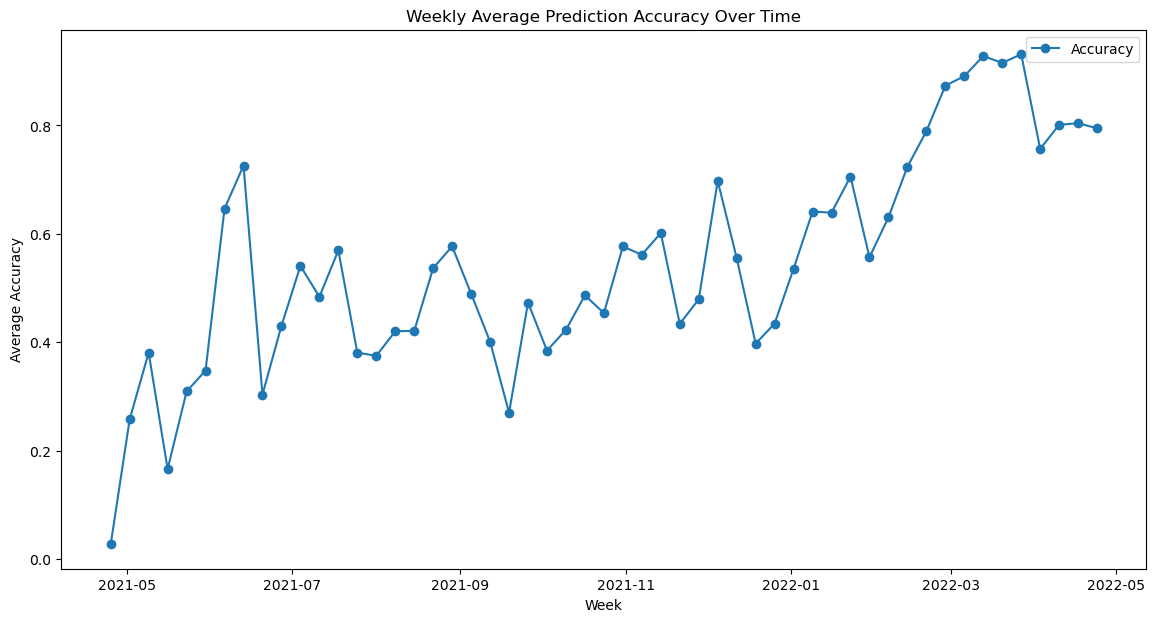

In [136]:
print(len(event_dates_test))
print(len(actual_labels_LSTM))
print(len(predicted_labels_LSTM))

event_dates_test = log_data_encoded.loc[X_test.index, 'event_date'].reset_index(drop=True)
event_dates_test = event_dates_test[:len(actual_labels_LSTM)]  # Slice event_dates_test to match the length

results_LSTM_df = pd.DataFrame({
    'event_date': event_dates_test,
    'actual_labels': actual_labels_LSTM,
    'predicted_labels': predicted_labels_LSTM
})

results_LSTM_df.index = pd.to_datetime(results_LSTM_df['event_date'])
results_LSTM_df['accuracy'] = (results_LSTM_df['actual_labels'] == results_LSTM_df['predicted_labels']).astype(int)
weekly_accuracy = results_LSTM_df['accuracy'].resample('W').mean()  # Change 'W' to 'M' for monthly

plt.figure(figsize=(14, 7))
plt.plot(weekly_accuracy.index, weekly_accuracy, label='Accuracy', marker='o')
plt.title('Weekly Average Prediction Accuracy Over Time')
plt.xlabel('Week')
plt.ylabel('Average Accuracy')
plt.legend()
plt.show()

/Users/Arya/miniforge3/envs/venv-metal/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/Arya/miniforge3/envs/venv-metal/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/Arya/miniforge3/envs/venv-metal/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

              precision    recall  f1-score      support
1              0.000000  0.000000  0.000000     1.000000
2              0.254369  0.861842  0.392804   152.000000
3              0.044184  0.304348  0.077165   161.000000
4              0.000000  0.000000  0.000000    14.000000
5              0.000000  0.000000  0.000000   439.000000
6              0.916667  0.174603  0.293333    63.000000
7              1.000000  0.022727  0.044444    44.000000
8              0.000000  0.000000  0.000000   108.000000
10             0.006944  0.500000  0.013699     2.000000
11             0.775393  0.966132  0.860317   561.000000
12             0.985294  0.247232  0.395280  2710.000000
14             0.933921  0.849132  0.889510   749.000000
15             0.968835  0.943894  0.956202  1515.000000
16             0.613333  0.654804  0.633391   281.000000
17             0.000000  0.000000  0.000000     7.000000
18             0.035971  0.030675  0.033113   163.000000
19             0.784375  0.4016

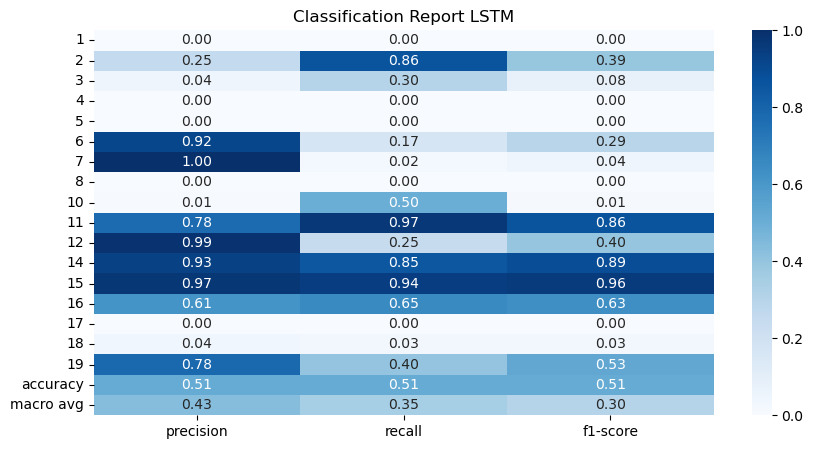

In [137]:
# Classification report
report_LSTM = classification_report(actual_classes_LSTM, y_pred_classes_LSTM, output_dict=True)
report_LSTM_df = pd.DataFrame(report_LSTM).transpose()
print(report_LSTM_df)

plt.figure(figsize=(10, 5))
sns.heatmap(report_LSTM_df.iloc[:-1, :-1], annot=True, fmt=".2f", cmap="Blues")
plt.title('Classification Report LSTM')
plt.show()

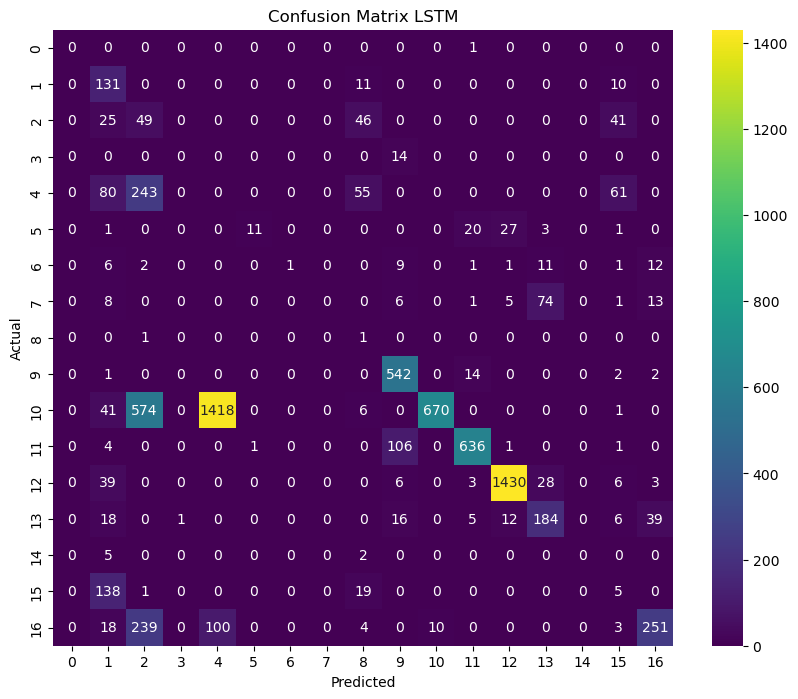

In [138]:
# Confusion Matrix
conf_matrix_LSTM = confusion_matrix(actual_classes_LSTM, y_pred_classes_LSTM)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_LSTM, annot=True, fmt='d', cmap='viridis')  # 'd' for integer format
plt.title('Confusion Matrix LSTM')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

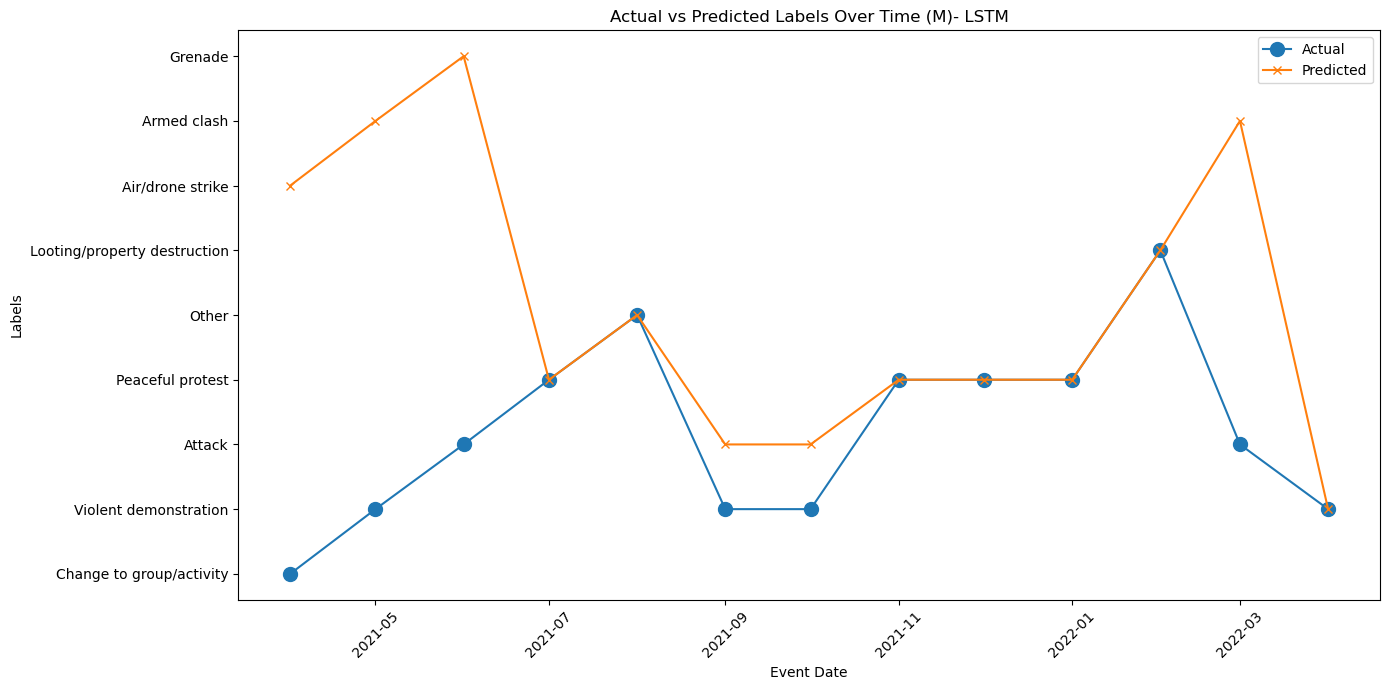

In [147]:
# Reset the index before sorting and converting event_date to monthly period
results_LSTM_df.reset_index(drop=True, inplace=True)
results_LSTM_df.sort_values('event_date', inplace=True)
#results_LSTM_df['event_date'] = results_LSTM_df['event_date'].dt.to_period('M')

# Convert the Period to the first day of each month for plotting
results_LSTM_df['plot_date'] = results_LSTM_df['event_date'].dt.start_time

# Group the data by plot_date and get the first value for each group
grouped_results_LSTM_df = results_LSTM_df.groupby('plot_date').first().reset_index()

plt.figure(figsize=(14, 7))
plt.plot(grouped_results_LSTM_df['plot_date'], grouped_results_LSTM_df['actual_labels'], label='Actual', marker='o', markersize='10')
plt.plot(grouped_results_LSTM_df['plot_date'], grouped_results_LSTM_df['predicted_labels'], label='Predicted', marker='x')
plt.title('Actual vs Predicted Labels Over Time (M)- LSTM')
plt.xlabel('Event Date')
plt.ylabel('Labels')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

The lines between the dates here represents a form of temporal "tracking" between certain sub-event types and specific months. 

In [168]:
#Grid Search for Hyperparamers - LSTM With Embedding
def create_model(n_features, n_nodes, dropout_rate, n_classes, n_input):
    model = Sequential()
    model.add(Input(shape=(n_input, n_features)))
    model.add(LSTM(n_nodes, return_sequences=True))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(n_nodes))
    model.add(Dropout(dropout_rate))
    model.add(Dense(n_classes, activation='softmax'))
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Define configurations
configs = [
    [X_train_reshaped.shape[2], 50, 0.1, 20, X_train_reshaped.shape[1]],  # Testing 10% dropout and 50 neurons, 24 time steps
    [X_train_reshaped.shape[2], 50, 0.2, 20, X_train_reshaped.shape[1]],  # Testing 20% dropout and 50 neurons, 24 time steps
    [X_train_reshaped.shape[2], 100, 0.2, 20, X_train_reshaped.shape[1]],  # Testing 20% dropout and 100 neurons, 24 time steps
    [X_train_reshaped.shape[2], 100, 0.3, 20, X_train_reshaped.shape[1]],  # Testing 30% dropout and 100 neurons, 24 time steps
]

# Function to run model with a specific config
def run_model(config):
    n_features, n_nodes, dropout_rate, n_classes, n_input = config
    model = create_model(n_features, n_nodes, dropout_rate, n_classes, n_input)
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    history = model.fit(X_train_reshaped, y_train_encoded, epochs=50, batch_size=64, validation_split=0.1, verbose=1, callbacks=[early_stopping])
    _, accuracy = model.evaluate(X_test_reshaped, y_test_encoded, verbose=0)
    return accuracy

# Grid search over configs
best_accuracy = 0
best_config = None
for config in configs:
    accuracy = run_model(config)
    print(f'Config: {config}, Accuracy: {accuracy:.3f}')
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_config = config

print(f'Best Config: {best_config}, Best Accuracy: {best_accuracy:.3f}')

Epoch 1/50


2024-05-01 12:23:40.924774: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-01 12:23:41.148721: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-01 12:23:41.559443: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-01 12:23:41.858685: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-01 12:23:42.162508: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


429/429 [==============================] - ETA: 0s - loss: 1.6192 - accuracy: 0.4373

2024-05-01 12:23:58.844845: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-01 12:23:58.999664: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-01 12:23:59.163396: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


429/429 [==============================] - 21s 43ms/step - loss: 1.6192 - accuracy: 0.4373 - val_loss: 2.0036 - val_accuracy: 0.3836
Epoch 2/50
429/429 [==============================] - 20s 48ms/step - loss: 1.0174 - accuracy: 0.6037 - val_loss: 1.4926 - val_accuracy: 0.4847
Epoch 3/50
429/429 [==============================] - 13s 30ms/step - loss: 0.8043 - accuracy: 0.6622 - val_loss: 1.7497 - val_accuracy: 0.4578
Epoch 4/50
429/429 [==============================] - 18s 42ms/step - loss: 0.7221 - accuracy: 0.6876 - val_loss: 1.6271 - val_accuracy: 0.5228
Epoch 5/50
429/429 [==============================] - 13s 31ms/step - loss: 0.6979 - accuracy: 0.6980 - val_loss: 0.7273 - val_accuracy: 0.6913
Epoch 6/50
429/429 [==============================] - 14s 33ms/step - loss: 0.6546 - accuracy: 0.7178 - val_loss: 1.8562 - val_accuracy: 0.4709
Epoch 7/50
429/429 [==============================] - 15s 34ms/step - loss: 0.6296 - accuracy: 0.7268 - val_loss: 0.7423 - val_accuracy: 0.7061
Epo

2024-05-01 12:26:25.028540: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-01 12:26:25.246458: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-01 12:26:25.556722: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-01 12:26:25.904413: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-01 12:26:26.446410: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


429/429 [==============================] - ETA: 0s - loss: 1.7653 - accuracy: 0.3726

2024-05-01 12:26:39.058057: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-01 12:26:39.122884: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-01 12:26:39.251595: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


429/429 [==============================] - 16s 32ms/step - loss: 1.7653 - accuracy: 0.3726 - val_loss: 2.8264 - val_accuracy: 0.1842
Epoch 2/50
429/429 [==============================] - 11s 26ms/step - loss: 1.4265 - accuracy: 0.4738 - val_loss: 2.8938 - val_accuracy: 0.2493
Epoch 3/50
429/429 [==============================] - 11s 26ms/step - loss: 1.0563 - accuracy: 0.5981 - val_loss: 1.6577 - val_accuracy: 0.4686
Epoch 4/50
429/429 [==============================] - 14s 32ms/step - loss: 0.8638 - accuracy: 0.6432 - val_loss: 1.0456 - val_accuracy: 0.6236
Epoch 5/50
429/429 [==============================] - 11s 26ms/step - loss: 0.8014 - accuracy: 0.6647 - val_loss: 1.2536 - val_accuracy: 0.5126
Epoch 6/50
429/429 [==============================] - 13s 29ms/step - loss: 0.7840 - accuracy: 0.6642 - val_loss: 0.9388 - val_accuracy: 0.6486
Epoch 7/50
429/429 [==============================] - 13s 31ms/step - loss: 0.7618 - accuracy: 0.6692 - val_loss: 1.1021 - val_accuracy: 0.6036
Epo

2024-05-01 12:30:29.231201: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-01 12:30:29.438600: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-01 12:30:29.651634: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-01 12:30:29.974486: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-01 12:30:30.266635: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


429/429 [==============================] - ETA: 0s - loss: 1.5186 - accuracy: 0.4586

2024-05-01 12:30:44.073909: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-01 12:30:44.143923: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-01 12:30:44.326993: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


429/429 [==============================] - 17s 35ms/step - loss: 1.5186 - accuracy: 0.4586 - val_loss: 2.2770 - val_accuracy: 0.3087
Epoch 2/50
429/429 [==============================] - 13s 30ms/step - loss: 0.8543 - accuracy: 0.6459 - val_loss: 1.9009 - val_accuracy: 0.4450
Epoch 3/50
429/429 [==============================] - 13s 30ms/step - loss: 0.7064 - accuracy: 0.6971 - val_loss: 1.4339 - val_accuracy: 0.5120
Epoch 4/50
429/429 [==============================] - 12s 28ms/step - loss: 0.6463 - accuracy: 0.7166 - val_loss: 1.2834 - val_accuracy: 0.5530
Epoch 5/50
429/429 [==============================] - 14s 33ms/step - loss: 0.6323 - accuracy: 0.7214 - val_loss: 1.1956 - val_accuracy: 0.6335
Epoch 6/50
429/429 [==============================] - 14s 32ms/step - loss: 0.6142 - accuracy: 0.7339 - val_loss: 1.2410 - val_accuracy: 0.6371
Epoch 7/50
429/429 [==============================] - 13s 31ms/step - loss: 0.6027 - accuracy: 0.7406 - val_loss: 1.3700 - val_accuracy: 0.6259
Epo

2024-05-01 12:35:00.952356: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-01 12:35:01.178179: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-01 12:35:01.717396: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-01 12:35:02.410817: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-01 12:35:02.737047: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


429/429 [==============================] - ETA: 0s - loss: 1.5854 - accuracy: 0.4421

2024-05-01 12:35:18.253484: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-01 12:35:18.317867: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-01 12:35:18.451358: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


429/429 [==============================] - 24s 39ms/step - loss: 1.5854 - accuracy: 0.4421 - val_loss: 2.9008 - val_accuracy: 0.2713
Epoch 2/50
429/429 [==============================] - 13s 30ms/step - loss: 1.0404 - accuracy: 0.5936 - val_loss: 2.5438 - val_accuracy: 0.3727
Epoch 3/50
429/429 [==============================] - 12s 29ms/step - loss: 0.8145 - accuracy: 0.6605 - val_loss: 0.7599 - val_accuracy: 0.6972
Epoch 4/50
429/429 [==============================] - 12s 29ms/step - loss: 0.7439 - accuracy: 0.6828 - val_loss: 1.3843 - val_accuracy: 0.5612
Epoch 5/50
429/429 [==============================] - 15s 36ms/step - loss: 0.6743 - accuracy: 0.7046 - val_loss: 1.5668 - val_accuracy: 0.5310
Epoch 6/50
429/429 [==============================] - 13s 30ms/step - loss: 0.6547 - accuracy: 0.7097 - val_loss: 1.4108 - val_accuracy: 0.5557
Epoch 7/50
429/429 [==============================] - 13s 31ms/step - loss: 0.6205 - accuracy: 0.7214 - val_loss: 0.6433 - val_accuracy: 0.7767
Epo

In [173]:
# Retraining LSTM WITH EMBED
def create_model(n_input, n_features, n_nodes, dropout_rate, n_classes):
    model = Sequential()

    # embedding layer
    model.add(Embedding(input_dim=len(np.unique(y)), output_dim=100, input_length=n_input))
    #flatten?
    model.add(Flatten())

    # LSTM layer
    model.add(LSTM(n_nodes, return_sequences=True))

    # dropout regularization
    model.add(Dropout(dropout_rate))

    # LSTM layer
    model.add(LSTM(n_nodes))

    # dropout regularization
    model.add(Dropout(dropout_rate))

    # output Dense layer with softmax (multi-class classification)
    model.add(Dense(n_classes, activation='softmax'))

    # model with categorical crossentropy loss and Adam optimizer
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

    return model

# best parameters
best_params = [14, 24, 100, 0.2, 20]  # Assuming n_input is 14 and n_features is 24

# Create and compile the model using the best parameters
LSTM_embed_model_best = create_model(*best_params)

# early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Reshape X_train and X_test to include timesteps
X_train_reshaped = create_sequences(X_train.to_numpy(), best_params[0])
X_test_reshaped = create_sequences(X_test.to_numpy(), best_params[0])

history = LSTM_embed_model_best.fit(X_train_reshaped, y_train_encoded, epochs=50, batch_size=64, validation_split=0.1, verbose=1, callbacks=[early_stopping])

ValueError: Input 0 of layer "lstm_70" is incompatible with the layer: expected ndim=3, found ndim=2. Full shape received: (None, 1400)

In [ ]:
loss_withembed, accuracy_withembed = LSTM_embed_model_best.evaluate(X_test_reshaped, y_test_encoded)

print(f'Test Accuracy With Embed: {accuracy_withembed:.2f}')

# predictions
y_pred_withembed = LSTM_embed_model_best.predict(X_test_reshaped)
y_pred_classes_withembed = np.argmax(y_pred_withembed, axis=1)

# actual class
actual_classes_withembed = np.argmax(y_test_encoded, axis=1) if y_test_encoded.ndim > 1 else y_test

# showing errors
errors_withembed = np.where(y_pred_classes_withembed != actual_classes_withembed)[0]
print(f'Number of errors With Embed: {len(errors_withembed)} / {len(actual_classes_withembed)}')

for i in errors_withembed[:10]:  # first 10
    print(f'Index: {i}, Predicted: {y_pred_classes_withembed[i]}, Actual: {actual_classes_withembed[i]}')

In [ ]:
predicted_labels_withembed = label_encoders['sub_event_type'].inverse_transform(y_pred_classes_withembed)
actual_labels_withembed = label_encoders['sub_event_type'].inverse_transform(actual_classes_withembed)

for actual, predicted in zip(actual_labels_withembed[:10], predicted_labels_withembed[:10]):
    print(f"Actual: {actual}, Predicted: {predicted}")

In [ ]:
# Accuracy over Time - weekly
results_withembed_df = pd.DataFrame({
    'event_date': log_data_encoded.loc[X_test.index, 'event_date'],
    'actual_labels': actual_labels_withembed,
    'predicted_labels': predicted_labels_withembed
})

results_withembed_df.index = pd.to_datetime(results_withembed_df['event_date'])

# stores prediction was correct
results_withembed_df['correct_prediction'] = (results_withembed_df['actual_labels'] == results_withembed_df['predicted_labels']).astype(int)

# weekly accuracy by taking the mean of pred.
weekly_accuracy_withembed = results_withembed_df['correct_prediction'].resample('W').mean()

plt.figure(figsize=(14, 7))
plt.plot(weekly_accuracy_withembed.index, weekly_accuracy_withembed, label='Accuracy', marker='o')
plt.title('Weekly Average Prediction Accuracy Over Time - With Embed')
plt.xlabel('Week')
plt.ylabel('Average Accuracy')
plt.legend()
plt.show()

In [ ]:
#  Classification report
report_withembed = classification_report(actual_classes_withembed, y_pred_classes_withembed, output_dict=True)
report_withembed_df = pd.DataFrame(report_withembed).transpose()
print(report_withembed_df)

plt.figure(figsize=(10, 5))
sns.heatmap(report_withembed_df.iloc[:-1, :-1], annot=True, fmt=".2f", cmap="Blues")
plt.title('Classification Report Heatmap With Embed')
plt.show()

In [ ]:
# Confusion Matrix
conf_matrix_withembed = confusion_matrix(actual_classes_withembed, y_pred_classes_withembed)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_withembed, annot=True, fmt='d', cmap='viridis')  # 'd' for integer format
plt.title('Confusion Matrix With Embed')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:
# Time-Series Plot
if 'event_date' in data.columns:
    event_dates_test_withembed = data.loc[X_test.index, 'event_date']
    results_withembed_df = pd.DataFrame({
        'event_date': event_dates_test_withembed,
        'actual_labels': label_encoders['sub_event_type'].inverse_transform(actual_classes_withembed),
        'predicted_labels': label_encoders['sub_event_type'].inverse_transform(y_pred_classes_withembed)
    })

    results_withembed_df.sort_values('event_date', inplace=True)

    plt.figure(figsize=(14, 7))
    plt.plot(results_withembed_df['event_date'], results_withembed_df['actual_labels'], label='Actual', marker='o')
    plt.plot(results_withembed_df['event_date'], results_withembed_df['predicted_labels'], label='Predicted', marker='x')
    plt.title('Actual vs Predicted Labels Over Time - LSTM With Embed')
    plt.xlabel('Event Date')
    plt.ylabel('Labels')
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

In [ ]:
#Creating OG Dataset (NO FEATURE SELECTION DATASET)

In [174]:
X_original = log_data_encoded.drop(['sub_event_type', 'event_date', 'source', 'notes'], axis=1)
y_original = log_data_encoded['sub_event_type']

X_original_train, X_original_test, y_original_train, y_original_test = train_test_split(X_original, y_original, test_size=0.2, random_state=42, shuffle=False)
y_original_train_encoded = tf.keras.utils.to_categorical(y_original_train)
y_original_test_encoded = tf.keras.utils.to_categorical(y_original_test)

KeyError: "['sub_event_type'] not found in axis"

In [ ]:
print(X_original_train.shape)
print(X_original_test.shape)
print(y_original_train.shape)
print(y_original_test.shape)
print("Encoded Y")
print(y_original_train_encoded.shape)
print(y_original_test_encoded.shape)
#print(X_original_train.dtypes)

In [ ]:
# LSTM Model without embedding and NOT ON SELECTED FEATURES
og_model_noembed = Sequential()
og_model_noembed.add(LSTM(50, return_sequences=True, input_shape=(X_original_train.shape[1], 1)))
og_model_noembed.add(Dropout(0.2))
og_model_noembed.add(LSTM(50))
og_model_noembed.add(Dropout(0.2))
og_model_noembed.add(Dense(y_original_train_encoded.shape[1], activation='softmax'))

og_model_noembed.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Fit the model
og_model_noembed.fit(X_original_train, y_original_train_encoded, epochs=25, batch_size=32, validation_split=0.1)

In [ ]:
# Evaluate the model
og_loss_noembed, og_accuracy_noembed = og_model_noembed.evaluate(X_original_test, y_original_test_encoded)
print(f'Test Accuracy for original non-embedding model: {og_accuracy_noembed:.2f}')

# predictions
og_y_pred_noembed = og_model_noembed.predict(X_original_test)
og_y_pred_classes_noembed = np.argmax(og_y_pred_noembed, axis=1)

#actual class
og_actual_classes_noembed = np.argmax(y_original_test_encoded, axis=1)

#showing errors
og_errors_noembed = np.where(og_y_pred_classes_noembed != og_actual_classes_noembed)[0]
print(f'Number of errors in original non-embedding model: {len(og_errors_noembed)} / {len(og_actual_classes_noembed)}')
for i in og_errors_noembed[:10]:  # first 10 
    print(f'Index: {i}, Predicted: {og_y_pred_classes_noembed[i]}, Actual: {og_actual_classes_noembed[i]}')

In [ ]:
og_predicted_labels_noembed = label_encoders['sub_event_type'].inverse_transform(og_y_pred_classes_noembed)

og_actual_labels_noembed = label_encoders['sub_event_type'].inverse_transform(og_actual_classes_noembed)

for actual, predicted in zip(og_actual_labels_noembed[:10], og_predicted_labels_noembed[:10]):
    print(f"Actual: {actual}, Predicted: {predicted}")

In [ ]:
#Accuracy over Time - weekly
og_results_noembed_df = pd.DataFrame({
    'event_date': log_data_encoded.loc[X_original_test.index, 'event_date'],
    'actual_labels': og_actual_labels_noembed,  
    'predicted_labels': og_predicted_labels_noembed  
})

#datetime index
og_results_noembed_df.index = pd.to_datetime(og_results_noembed_df['event_date'])

#was each prediction was correct?
og_results_noembed_df['correct_prediction'] = (og_results_noembed_df['actual_labels'] == og_results_noembed_df['predicted_labels']).astype(int)

# weekly accuracy by taking the mean of 'correct_prediction'
weekly_accuracy_og_noembed = og_results_noembed_df['correct_prediction'].resample('W').mean()

plt.figure(figsize=(14, 7))
plt.plot(weekly_accuracy_og_noembed.index, weekly_accuracy_og_noembed, label='Accuracy', marker='o')
plt.title('Weekly Average Prediction Accuracy Over Time - Original Non-Embedding Model')
plt.xlabel('Week')
plt.ylabel('Average Accuracy')
plt.legend()
plt.show()

In [ ]:
# Classification report
og_report_noembed = classification_report(og_actual_classes_noembed, og_y_pred_classes_noembed, output_dict=True)
og_report_noembed_df = pd.DataFrame(og_report_noembed).transpose()
print(og_report_noembed_df)

plt.figure(figsize=(10, 5))
sns.heatmap(og_report_noembed_df.iloc[:-1, :-1], annot=True, fmt=".2f", cmap="Blues")
plt.title('Classification Report Heatmap for original non-embedding model')
plt.show()

In [ ]:
#Confusion Matrix
og_conf_matrix_noembed = confusion_matrix(og_actual_classes_noembed, og_y_pred_classes_noembed)
plt.figure(figsize=(10, 8))
sns.heatmap(og_conf_matrix_noembed, annot=True, fmt='d', cmap='viridis')
plt.title('Confusion Matrix for original non-embedding model')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:
# Set 'event_date' as the index if it isn't already
if 'event_date' not in og_results_noembed_df.index.names:
    og_results_noembed_df.set_index('event_date', inplace=True)

# Convert the index to datetime if it's not already
og_results_noembed_df.index = pd.to_datetime(og_results_noembed_df.index)

# Plotting
plt.figure(figsize=(14, 7))
plt.plot(og_results_noembed_df.index, og_results_noembed_df['actual_labels'], label='Actual', marker='o')
plt.plot(og_results_noembed_df.index, og_results_noembed_df['predicted_labels'], label='Predicted', marker='x')
plt.title('Actual vs Predicted Labels Over Time - Original Non-Embedding Model')
plt.xlabel('Event Date')
plt.ylabel('Labels')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


In [145]:
#VAR Model?

#flattening for data purposes
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_val_flat = X_val.reshape(X_val.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

model = VAR(X_train_flat)
model_fitted = model.fit()


AttributeError: 'DataFrame' object has no attribute 'reshape'

In [ ]:
predictions = model_fitted.forecast(model_fitted.y, steps=len(X_val_flat))

mse = mean_squared_error(X_val_flat, predictions)
print("Mean Squared Error:", mse)
plt.plot(X_val_flat, label='Actual')
plt.plot(predictions, label='Predicted')
plt.legend()
plt.show()